# Topic Modeling

Large amounts of data are collected everyday. As more information becomes available, it becomes difficult to access what we are looking for. So, we need tools and techniques to organize, search and understand vast quantities of information.

Topic modelling provides us with methods to organize, understand and summarize large collections of textual information. It helps in:

* Discovering hidden topical patterns that are present across the collection
* Annotating documents according to these topics
* Using these annotations to organize, search and summarize texts

Topic modelling can be described as a method for finding a group of words (i.e topic) from a collection of documents that best represents the information in the collection. It can also be thought of as a form of text mining – a way to obtain recurring patterns of words in textual material.

In [1]:
import pandas as pd
import numpy as np
import re

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

# spacy for lemmatization
# import spacy
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# this will slove broken link issue with nltk using ssl.
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/saikumaryava/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saikumaryava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### The Data
The data set we’ll use is a list of over one million news headlines published over a period of 15 years and can be downloaded from [Kaggle](https://www.kaggle.com/therohk/million-headlines/data#abcnews-date-text.csv).

In [4]:
data = pd.read_csv('abcnews-date-text.csv', error_bad_lines=False);
data_text = data[['headline_text']]
data_text['index'] = data_text.index
documents = data_text

In [5]:
documents.head()

,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4


In [6]:
documents.shape

(1103663, 2)

### Data Pre-processing
We will perform the following steps:

* **Tokenization**: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.
* Words that have fewer than 3 characters are removed.
* All **stopwords** are removed.
* Words are **lemmatized** — words in third person are changed to first person and verbs in past and future tenses are changed into present.
* Words are **stemmed** — words are reduced to their root form.

In [7]:
# perform lemmatize and stem preprocessing steps on the data set.
stemmer = SnowballStemmer(language='english',ignore_stopwords=True)
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [8]:
# preview after preprocessing
doc_sample = documents[documents['index'] == 4310].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['rain', 'helps', 'dampen', 'bushfires']


 tokenized and lemmatized document: 
['rain', 'help', 'dampen', 'bushfir']


In [9]:
# Preprocess the headline text, saving the results as ‘processed_docs’
processed_docs = documents['headline_text'].map(preprocess)
processed_docs.head(10)

0            [decid, communiti, broadcast, licenc]
1                               [wit, awar, defam]
2           [call, infrastructur, protect, summit]
3                      [staff, aust, strike, rise]
4             [strike, affect, australian, travel]
5               [ambiti, olsson, win, tripl, jump]
6           [antic, delight, record, break, barca]
7    [aussi, qualifi, stosur, wast, memphi, match]
8            [aust, address, secur, council, iraq]
9                         [australia, lock, timet]
Name: headline_text, dtype: object

Create a dictionary from ‘processed_docs’ containing the number of times a word appears in the training set.

In [10]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 broadcast
1 communiti
2 decid
3 licenc
4 awar
5 defam
6 wit
7 call
8 infrastructur
9 protect
10 summit


Filter out tokens that appear in less than 15 documents (absolute number) or
more than 0.5 documents (fraction of total corpus size, not absolute number).
after the above two steps, keep only the first 100000 most frequent tokens.

In [11]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

### Gensim doc2bow

For each document we create a dictionary reporting how many
words and how many times those words appear. Save this to ‘bow_corpus’, then check our selected document earlier.

In [12]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(76, 1), (112, 1), (484, 1), (4015, 1)]

In [13]:
# Preview Bag Of Words for our sample preprocessed document.
bow_doc_4310 = bow_corpus[4310]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 76 ("bushfir") appears 1 time.
Word 112 ("help") appears 1 time.
Word 484 ("rain") appears 1 time.
Word 4015 ("dampen") appears 1 time.


### TF-IDF
Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

In [14]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    print(doc)
    break

[(0, 0.5893154583024485), (1, 0.3892866165028569), (2, 0.49651921997736453), (3, 0.5046106271280878)]


# Building the Topic Models

## 1. Latent Dirichlet Allocation (LDA)

### What does LDA do?

Topic modeling is a type of statistical modeling for discovering the abstract “topics” that occur in a collection of documents. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions.
Here we are going to apply LDA to a set of documents and split them into topics.

Train the lda models using **gensim.models.LdaMulticore** and **gensim.models.wrappers.LdaMallet**

### Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

### Visualize the topics-keywords
Examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

## LDA using Bag of Words

In [15]:
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
#                                            id2word=dictionary,
#                                            num_topics=10, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

### Building LdaMulticore Model

In [16]:
# Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [17]:
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.022*"warn" + 0.021*"market" + 0.019*"health" + 0.018*"rural" + 0.018*"hospit" + 0.015*"share" + 0.014*"break" + 0.013*"citi" + 0.012*"news" + 0.011*"street"
Topic: 1 
Words: 0.046*"australian" + 0.028*"melbourn" + 0.025*"adelaid" + 0.020*"test" + 0.019*"women" + 0.017*"tasmanian" + 0.016*"open" + 0.016*"win" + 0.011*"vote" + 0.011*"darwin"
Topic: 2 
Words: 0.021*"chang" + 0.016*"miss" + 0.016*"tasmania" + 0.015*"help" + 0.014*"council" + 0.013*"farmer" + 0.012*"fund" + 0.012*"fall" + 0.012*"busi" + 0.010*"search"
Topic: 3 
Words: 0.029*"govern" + 0.021*"south" + 0.016*"countri" + 0.016*"north" + 0.014*"hour" + 0.013*"power" + 0.013*"west" + 0.013*"indigen" + 0.013*"turnbul" + 0.011*"victoria"
Topic: 4 
Words: 0.020*"die" + 0.019*"live" + 0.018*"coast" + 0.018*"donald" + 0.014*"gold" + 0.014*"lose" + 0.012*"park" + 0.012*"crash" + 0.012*"royal" + 0.011*"beat"
Topic: 5 
Words: 0.022*"school" + 0.017*"sydney" + 0.015*"time" + 0.015*"record" + 0.013*"elect" + 0.013*"trai

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.83420727940578

Coherence Score:  0.18375082231251125


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.196806 -0.289105       1        1  11.546267
2     -0.267694 -0.014603       2        1  11.530755
3     -0.244419  0.039839       3        1  11.353895
7      0.082821  0.252375       4        1  10.298702
9      0.049882 -0.228370       5        1   9.775863
0     -0.118370 -0.023184       6        1   9.765476
5     -0.123440 -0.060494       7        1   9.426515
1      0.163453  0.065367       8        1   8.984342
4      0.160066  0.105976       9        1   8.806295
8      0.100895  0.152200      10        1   8.511888, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
16    Default  21350.000000  australian  21350.000000  30.0000  30.0000
37    Default  26732.000000   australia  26732.000000  29.0000  29.0000
236   Default  28355.000000       polic  28355.000000  28.0000  28.0000
1104  Default  16346.000000        year  16346.000000  27.0000  27.0000
6596  Default  16990.000000       trump  16990.000000  26.0000  26.0000
2393  Default  16361.000000      govern  16361.000000  25.0000  25.0000
320   Default  16457.000000       charg  16457.000000  24.0000  24.0000
212   Default  15591.000000       court  15591.000000  23.0000  23.0000
1992  Default  13170.000000  queensland  13170.000000  22.0000  22.0000
844   Default  12465.000000    melbourn  12465.000000  21.0000  21.0000
109   Default  11569.000000        home  11569.000000  20.0000  20.0000
966   Default  11010.000000     adelaid  11010.000000  19.0000  19.0000
301   Default  12027.000000      murder  12027.000000  18.0000  18.0000
175   Default  11993.000000       chang  11993.000000  17.0000  17.0000
143   Default  11842.000000       south  11842.000000  16.0000  16.0000
282   Default  10134.000000        hous  10134.000000  15.0000  15.0000
344   Default  10474.000000        warn  10474.000000  14.0000  14.0000
1762  Default   9625.000000       perth   9625.000000  13.0000  13.0000
1034  Default  10029.000000      school  10029.000000  12.0000  12.0000
1098  Default  10081.000000      market  10081.000000  11.0000  11.0000
1183  Default   9495.000000    canberra   9495.000000  10.0000  10.0000
80    Default  13954.000000      attack  13954.000000   9.0000   9.0000
422   Default  12446.000000       world  12446.000000   8.0000   8.0000
530   Default  12279.000000        kill  12279.000000   7.0000   7.0000
426   Default  10039.000000        face  10039.000000   6.0000   6.0000
575   Default   8868.000000        test   8868.000000   5.0000   5.0000
172   Default   8782.000000         die   8782.000000   4.0000   4.0000
258   Default   8959.000000      health   8959.000000   3.0000   3.0000
2143  Default  15808.000000      sydney  15808.000000   2.0000   2.0000
360   Default   8531.000000       women   8531.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
1183  Topic10   9495.070312    canberra   9495.895508   2.4636  -3.7843
276   Topic10   6109.952148    investig   6110.776855   2.4636  -4.2251
1515  Topic10   6019.403809    children   6020.228516   2.4636  -4.2401
1840  Topic10   4977.674316      budget   4978.499023   2.4635  -4.4301
1492  Topic10   4671.375000        game   4672.199707   2.4635  -4.4936
639   Topic10   4653.467285      releas   4654.291992   2.4635  -4.4974
356   Topic10   4267.072266       young   4267.896973   2.4635  -4.5841
375   Topic10   4029.607178         get   4030.432129   2.4635  -4.6414
548   Topic10   3786.642334      reveal   3787.467285   2.4635  -4.7036
541   Topic10   3644.960205       shark   3645.785156   2.4635  -4.7417
1056  Topic10   3594.629395        play   3595.454346   2.4635  -4.7556
43    Topic10   3545.635742      celebr   3546.460693   2.4635  -4.7693
685   Topic10   3482.448730        mark   3483.273682   2.4635  -4.78

### Building LDA Mallet Model

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [ ]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
! wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [20]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, num_topics=10, id2word=dictionary)

In [21]:
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in ldamallet.show_topics(formatted=False):
    print('Topic: {} \nWords: {}'.format(idx, topic))
print()

Topic: 0 
Words: [('sydney', 0.021140068044792626), ('miss', 0.02112523885586452), ('south', 0.017227280623334364), ('continu', 0.016767575766563146), ('australia', 0.015663860419199985), ('china', 0.015271946140385814), ('hold', 0.012793353133831311), ('search', 0.01272979946699658), ('australian', 0.012299752988081569), ('deal', 0.01155617508611522)]
Topic: 1 
Words: [('interview', 0.033123198049517126), ('elect', 0.019112538728094503), ('labor', 0.014875384644587347), ('state', 0.012036554681222174), ('leader', 0.011087465911895035), ('chief', 0.009870523201002238), ('talk', 0.009294742680943774), ('campaign', 0.008457435477781832), ('parti', 0.008278163154686706), ('speak', 0.008179036105445871)]
Topic: 2 
Words: [('year', 0.02350199521149242), ('nation', 0.019247672253258845), ('rural', 0.015702048417132217), ('record', 0.014365522745411013), ('centr', 0.014116520351157222), ('time', 0.013352487363660548), ('break', 0.013205639797818568), ('countri', 0.012837456770417664), ('melbo

In [23]:
# Compute Perplexity
# print('\nPerplexity: ', ldamallet.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.24432629110868823


In [25]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(ldamallet, bow_corpus, dictionary)
# vis

## LDA using TF-IDF

### Building LdaMulticore Model

In [26]:
# Train our lda model using gensim.models.LdaMulticore and save it to ‘lda_model’
lda_model_tf_idf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [27]:
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model_tf_idf.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.018*"tasmania" + 0.011*"street" + 0.009*"sexual" + 0.007*"coal" + 0.007*"intern" + 0.006*"insid" + 0.006*"fire" + 0.005*"tree" + 0.005*"light" + 0.005*"giant"
Topic: 1 
Words: 0.010*"health" + 0.008*"mother" + 0.008*"michael" + 0.007*"aborigin" + 0.007*"mental" + 0.007*"juli" + 0.007*"quiz" + 0.007*"care" + 0.006*"action" + 0.006*"grand"
Topic: 2 
Words: 0.012*"abus" + 0.010*"child" + 0.010*"commiss" + 0.009*"children" + 0.008*"sport" + 0.007*"damag" + 0.007*"cricket" + 0.007*"ash" + 0.007*"appeal" + 0.006*"parent"
Topic: 3 
Words: 0.013*"market" + 0.011*"govern" + 0.010*"share" + 0.008*"price" + 0.007*"bank" + 0.007*"fund" + 0.006*"australian" + 0.006*"rugbi" + 0.006*"rat" + 0.006*"dollar"
Topic: 4 
Words: 0.012*"royal" + 0.010*"violenc" + 0.010*"christma" + 0.008*"domest" + 0.008*"state" + 0.008*"grandstand" + 0.008*"refuge" + 0.007*"islam" + 0.007*"histori" + 0.007*"great"
Topic: 5 
Words: 0.013*"turnbul" + 0.008*"malcolm" + 0.007*"final" + 0.007*"world" + 0.006*"

In [28]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_tf_idf.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tf_idf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.019154856229479

Coherence Score:  0.37255007302290766


In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tf_idf, corpus_tfidf, dictionary)
vis

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.155265 -0.096645       1        1  12.662148
8      0.336377 -0.137318       2        1  11.495033
5      0.033806  0.237282       3        1  10.092025
9     -0.077737  0.203936       4        1  10.055312
7     -0.150118 -0.093380       5        1   9.730824
1     -0.071998 -0.090802       6        1   9.424886
4      0.097385  0.160615       7        1   9.353309
2      0.055370 -0.092804       8        1   9.184210
6     -0.122798 -0.072872       9        1   9.133300
0      0.054978 -0.018012      10        1   8.868954, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
6596   Default  6886.000000       trump  6886.000000  30.0000  30.0000
418    Default  4496.000000     countri  4496.000000  29.0000  29.0000
1406   Default  3946.000000        hour  3946.000000  28.0000  28.0000
363    Default  3747.000000        live  3747.000000  27.0000  27.0000
1530   Default  3567.000000      donald  3567.000000  26.0000  26.0000
2253   Default  3505.000000    tasmania  3505.000000  25.0000  25.0000
320    Default  5239.000000       charg  5239.000000  24.0000  24.0000
1248   Default  4205.000000       rural  4205.000000  23.0000  23.0000
1078   Default  3706.000000       woman  3706.000000  22.0000  22.0000
193    Default  3531.000000       crash  3531.000000  21.0000  21.0000
301    Default  4082.000000      murder  4082.000000  20.0000  20.0000
1098   Default  4032.000000      market  4032.000000  19.0000  19.0000
5658   Default  2908.000000     turnbul  2908.000000  18.0000  18.0000
1675   Default  3051.000000       shoot  3051.000000  17.0000  17.0000
2833   Default  2828.000000        drum  2828.000000  16.0000  16.0000
1252   Default  2756.000000        news  2756.000000  15.0000  15.0000
1992   Default  5194.000000  queensland  5194.000000  14.0000  14.0000
1152   Default  2892.000000       share  2892.000000  13.0000  13.0000
2123   Default  2466.000000       royal  2466.000000  12.0000  12.0000
1884   Default  2386.000000        abus  2386.000000  11.0000  11.0000
1300   Default  3390.000000   interview  3390.000000  10.0000  10.0000
1229   Default  2259.000000     marriag  2259.000000   9.0000   9.0000
2782   Default  2222.000000      street  2222.000000   8.0000   8.0000
306    Default  3375.000000       alleg  3375.000000   7.0000   7.0000
202    Default  2179.000000     violenc  2179.000000   6.0000   6.0000
236    Default  7248.000000       polic  7248.000000   5.0000   5.0000
1921   Default  2103.000000      hobart  2103.000000   4.0000   4.0000
172    Default  3411.000000         die  3411.000000   3.0000   3.0000
694    Default  2027.000000    christma  2027.000000   2.0000   2.0000
11892  Default  1977.000000     podcast  1977.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
469    Topic10  1398.682739      intern  1399.578979   2.4220  -4.9589
3228   Topic10  1232.504517       insid  1233.400757   2.4219  -5.0853
2183   Topic10  1213.979492        fire  1214.875977   2.4219  -5.1005
584    Topic10  1094.836792        tree  1095.733032   2.4218  -5.2038
1341   Topic10  1060.910767       giant  1061.807007   2.4218  -5.2353
578    Topic10  1055.052979      rememb  1055.949219   2.4218  -5.2408
1600   Topic10  1009.192017      valley  1010.088257   2.4217  -5.2852
2191   Topic10  1006.030090       onlin  1006.926331   2.4217  -5.2884
611    Topic10   933.554626     william   934.450867   2.4217  -5.3631
1920   Topic10   910.761475      histor   911.657715   2.4216  -5.3879
2066   Topic10   908.827026        walk   909.723267   2.4216  -5.3900
391    Topic10   899.077576         run   899.975220   2.4216  -5.4008
1082   Topic10   880.696838     destroy   881.593079   2.4216  -5.4214
1396   Topic10   877.093201       updat   8

### Building LDA Mallet Model

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [30]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet_tf_idf = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=10, id2word=dictionary)

In [31]:
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in ldamallet_tf_idf.show_topics(formatted=False):
    print('Topic: {} \nWords: {}'.format(idx, topic))
print()

Topic: 0 
Words: [('rural', 0.15715202052597818), ('open', 0.036561898652982684), ('charg', 0.025016035920461834), ('chang', 0.02052597819114817), ('arrest', 0.01796023091725465), ('wrap', 0.01731879409878127), ('school', 0.01731879409878127), ('polic', 0.014753046824887749), ('trial', 0.012828736369467608), ('fund', 0.011545862732520847)]
Topic: 1 
Words: [('interview', 0.225923682616596), ('busi', 0.10175651120533011), ('corner', 0.025439127801332527), ('report', 0.021804966686856452), ('job', 0.019987886129618413), ('year', 0.015748031496062992), ('death', 0.015142337976983646), ('road', 0.012719563900666263), ('dairi', 0.012113870381586917), ('fight', 0.01150817686250757)]
Topic: 2 
Words: [('closer', 0.21552795031055902), ('die', 0.031055900621118012), ('budget', 0.02360248447204969), ('futur', 0.018012422360248446), ('power', 0.015527950310559006), ('station', 0.013664596273291925), ('plan', 0.013664596273291925), ('green', 0.010559006211180125), ('sydney', 0.009937888198757764),

In [32]:
# Compute Perplexity
#print('\nPerplexity: ', lda_model_tf_idf.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamallet_tf_idf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4783961208278867


In [33]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(ldamallet_tf_idf, corpus_tfidf, dictionary)
# vis

### How to find the optimal number of topics for LDA?

Finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, start=2, limit=40, step=6)

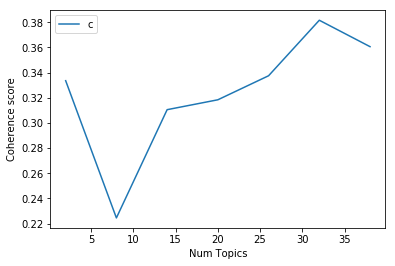

In [38]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3335
Num Topics = 8  has Coherence Value of 0.2245
Num Topics = 14  has Coherence Value of 0.3105
Num Topics = 20  has Coherence Value of 0.3183
Num Topics = 26  has Coherence Value of 0.3374
Num Topics = 32  has Coherence Value of 0.3815
Num Topics = 38  has Coherence Value of 0.3605


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 14 topics itself.

In [44]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.105*"polic" + 0.038*"crash" + 0.029*"miss" + 0.023*"road" + 0.022*"die" + 0.022*"continu" + 0.022*"investig" + 0.021*"dead" + 0.020*"shoot" + 0.019*"driver"'), (1, '0.065*"plan" + 0.054*"council" + 0.024*"fear" + 0.023*"seek" + 0.022*"concern" + 0.019*"centr" + 0.018*"public" + 0.016*"communiti" + 0.016*"park" + 0.015*"mayor"'), (2, '0.028*"market" + 0.027*"rise" + 0.023*"australian" + 0.022*"price" + 0.021*"hous" + 0.021*"busi" + 0.020*"record" + 0.019*"high" + 0.018*"year" + 0.017*"close"'), (3, '0.031*"open" + 0.022*"sydney" + 0.013*"australian" + 0.012*"protest" + 0.012*"brisban" + 0.012*"rescu" + 0.012*"island" + 0.012*"river" + 0.011*"darwin" + 0.010*"violenc"'), (4, '0.043*"kill" + 0.035*"attack" + 0.028*"claim" + 0.026*"elect" + 0.021*"labor" + 0.017*"iraq" + 0.017*"state" + 0.015*"fight" + 0.014*"bomb" + 0.013*"vote"'), (5, '0.027*"nation" + 0.024*"win" + 0.022*"rural" + 0.018*"break" + 0.018*"countri" + 0.017*"adelaid" + 0.016*"time" + 0.016*"hour" + 0.015*"news" + 0.

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [45]:
# de-tokenization
detokenized_doc = []
for text in processed_docs:
    t = ' '.join(text)
    detokenized_doc.append(t)

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=detokenized_doc):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=bow_corpus, texts=detokenized_doc)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

### Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

### Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

## 2. Latent Semantic Analysis (LSA)

Latent Semantic Analysis (LSA) comes into play as it attempts to leverage the context around the words to capture the hidden concepts, also known as topics.

So, simply mapping words to documents won’t really help. What we really need is to figure out the hidden concepts or topics behind the words. LSA is one such technique that can find these hidden topics. Let’s now deep dive into the inner workings of LSA.

### Document-Term Matrix
This is the first step towards topic modeling. We will use sklearn’s TfidfVectorizer to create a document-term matrix with 1,000 terms.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(detokenized_doc)

X.shape # check shape of the document-term matrix

(1103663, 1000)

In [16]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

The components of svd_model are our topics, and we can access them using svd_model.components_. Finally, let’s print a few most important words in each of the 20 topics and see how our model has done.

In [17]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 
interview
 
extend
 
michael
 
john
 
david
 
smith
 
jam
 
Topic 1: 
polic
 
charg
 
court
 
murder
 
investig
 
death
 
crash
 
Topic 2: 
plan
 
say
 
council
 
charg
 
govt
 
court
 
face
 
Topic 3: 
charg
 
court
 
face
 
murder
 
drug
 
assault
 
woman
 
Topic 4: 
say
 
australia
 
kill
 
report
 
need
 
australian
 
minist
 
Topic 5: 
plan
 
charg
 
say
 
polic
 
murder
 
assault
 
drug
 
Topic 6: 
kill
 
crash
 
plan
 
die
 
attack
 
charg
 
say
 
Topic 7: 
court
 
face
 
accus
 
plan
 
say
 
tell
 
jail
 
Topic 8: 
australia
 
plan
 
court
 
face
 
world
 
south
 
accus
 
Topic 9: 
council
 
australia
 
kill
 
crash
 
say
 
court
 
face
 
Topic 10: 
report
 
council
 
rural
 
court
 
plan
 
face
 
news
 
Topic 11: 
open
 
australian
 
year
 
win
 
miss
 
warn
 
market
 
Topic 12: 
crash
 
die
 
death
 
fatal
 
road
 
driver
 
hospit
 
Topic 13: 
warn
 
water
 
death
 
attack
 
flood
 
rise
 
issu
 
Topic 14: 
year
 
jail
 
death
 
murder
 
attack
 
miss
 
woman
 
Topi

### Topics Visualization

In [ ]:
import umap.umap_ as umap

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()